In [1]:
import sys
import pandas as pd
import numpy as np
import os
from functools import reduce
import datetime
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import (
    auc,
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
)
from sklearn.model_selection import GridSearchCV, train_test_split

sys.path.append("..")

from shift_detector import *
from shift_reductor import *
from shift_experiments import *
from shift_explainer import *
from shift_tester import *
from shift_utils import *
from shift_models import *
from shift_constants import *
from shift_plot_utils import *

sys.path.append("../..")

import sqlalchemy
from sqlalchemy import select, func, extract, desc
from sqlalchemy.sql.expression import and_

from evidently import ColumnMapping
from evidently.dashboard import Dashboard
from evidently.dashboard.tabs import DataQualityTab
from evidently.model_profile import Profile
from evidently.model_profile.sections import DataQualityProfileSection

import config
import cyclops
from cyclops.processors.column_names import (
    ENCOUNTER_ID,
    HOSPITAL_ID,
    ADMIT_TIMESTAMP,
    DISCHARGE_TIMESTAMP,
    DISCHARGE_DISPOSITION,
    READMISSION,
    AGE,
    SEX,
    TOTAL_COST,
    CITY,
    PROVINCE,
    COUNTRY,
    LANGUAGE,
    LENGTH_OF_STAY_IN_ER,
    VITAL_MEASUREMENT_NAME,
    VITAL_MEASUREMENT_VALUE,
    VITAL_MEASUREMENT_TIMESTAMP,
    LAB_TEST_NAME,
    LAB_TEST_TIMESTAMP,
    LAB_TEST_RESULT_VALUE,
    LAB_TEST_RESULT_UNIT,
    REFERENCE_RANGE,
)
from cyclops.processors.constants import EMPTY_STRING
from cyclops.processors.admin import AdminProcessor
from cyclops.processors.vitals import VitalsProcessor
from cyclops.processors.labs import LabsProcessor
from cyclops.processors.outcomes import OutcomesProcessor
from cyclops.processors.feature_handler import FeatureHandler
from cyclops.orm import Database

%reload_ext autoreload
%reload_ext nb_black

2022-04-26 07:15:58.600278: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/R/4.0.4/lib/R/lib::/lib:/usr/local/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/java-11-openjdk-amd64/lib/server
2022-04-26 07:15:58.600349: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-04-26 07:16:01.260185: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-26 07:16:01.260256: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cpu1.gemini-hpc.ca): /proc/driver/nvidia/version does not exist
2022-04-26 07:16:01.261310: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is 

<IPython.core.display.Javascript object>

### Define Parameters ###

In [22]:
PATH = "/mnt/nfs/project/delirium/drift_exp/"
DATASET = "gemini"
RANDOM_RUNS = 5
SIGN_LEVEL = 0.05
NA_CUTOFF = 0.60
dr_techniques = ["NoRed", "SRP", "PCA", "BBSDs_FFNN"]
md_tests = ["MMD", "LSDD","LK"]
samples = [10, 20, 50, 100, 200, 500, 1000, 2000]
calc_acc = True
shift_type = input("Select shift experiment: ")
OUTCOME = input("Select outcome variable: ")
HOSPITAL = [input("Select hospital: ")]

# Define shift types.
if shift_type =='ko_shift':
    shifts = ['ko_shift_0.1','ko_shift_0.5','ko_shift_1.0']
elif shift_type == 'small_gn_shift':
    shifts = ['small_gn_shift_0.1','small_gn_shift_0.5','small_gn_shift_1.0']
elif shift_type == 'medium_gn_shift':
    shifts = ['medium_gn_shift_0.1', 'medium_gn_shift_0.5','medium_gn_shift_1.0']
elif shift_type == 'large_gn_shift':
    shifts = ['large_gn_shift_0.1','large_gn_shift_0.5','large_gn_shift_1.0']
elif shift_type == 'mfa_shift':
    shifts = ['mfa_shift_0.25','mfa_shift_0.5']#,'mfa_shift_0.75']
elif shift_type == 'cp_shift':
    shifts = ['cp_shift_0.25','cp_shift_0.75']
elif shift_type == 'small_bn_shift':
    shifts = ['small_bn_shift_0.1','small_bn_shift_0.5','small_bn_shift_1.0']
elif shift_type == 'medium_bn_shift':
    shifts = ['medium_bn_shift_0.1','medium_bn_shift_0.5','medium_bn_shift_1.0']
elif shift_type == 'large_bn_shift':
    shifts = ['large_bn_shift_0.1','large_bn_shift_0.5','large_bn_shift_1.0']


Select shift experiment: large_bn_shift
Select outcome variable: length_of_stay_in_er
Select hospital: MSH


<IPython.core.display.Javascript object>

## Run Shift Experiments ##

In [ ]:
if os.path.exists(PATH + "/mean_dr_md_" + shift_type + ".pkl"):
    with open(PATH + "/mean_dr_md_" + shift_type + ".pkl", "rb") as f:
        mean_shifts_dr_md = pickle.load(f)
else:
    mean_shifts_dr_md = np.ones((len(shifts), len(dr_techniques),len(md_tests),len(samples))) * (-1)
if os.path.exists(PATH + "/std_dr_md_" + shift_type + ".pkl"):
    with open(PATH + "/std_dr_md_" + shift_type + ".pkl", "rb") as f:
        std_shifts_dr_md = pickle.load(f)
else:
    std_shifts_dr_md = np.ones((len(shifts), len(dr_techniques),len(md_tests),len(samples))) * (-1)

for si, shift in enumerate(shifts):
    for di, dr_technique in enumerate(dr_techniques):
        for mi, md_test in enumerate(md_tests):
            if np.any(mean_shifts_dr_md[si, di, mi, :] == -1):
                print(
                            "{} | {} | {} ".format(
                                shift, dr_technique, md_test
                            )
                        )
                try:
                    mean_p_vals, std_p_vals = run_synthetic_shift_experiment(shift, 
                                                                        OUTCOME,
                                                                        HOSPITAL,
                                                                        PATH,
                                                                        dr_technique,
                                                                        md_test,
                                                                        samples,
                                                                        DATASET,
                                                                        SIGN_LEVEL,
                                                                        NA_CUTOFF,
                                                                        RANDOM_RUNS,
                                                                        calc_acc=True)
                    mean_shifts_dr_md[si,di,mi,:] = mean_p_vals
                    std_shifts_dr_md[si,di,mi,:] = std_p_vals
                except ValueError as e:
                    print("Value Error")
                    pass


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
2022-04-26 12:01:48,566 INFO cyclops.processors.base - Processing raw admin data...
2022-04-26 12:01:48,573 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-26 12:01:48,582 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


large_bn_shift_0.1 | NoRed | MMD 
Shift large_bn_shift_0.1


2022-04-26 12:02:36,163 INFO cyclops.utils.profile - Finished executing function process in 47.596023 s


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.6899999976158142
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.800000011920929
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.7300000190734863
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.7900000214576721
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.019999999552965164
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.07999999821186066
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.15000000596046448
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.


2022-04-26 12:02:39,963 INFO cyclops.processors.base - Processing raw admin data...
2022-04-26 12:02:39,973 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-26 12:02:39,982 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


Shift p-vals:  0.18000000715255737


In [17]:
if not os.path.exists(PATH + "/mean_dr_md_" + shift_type + ".pkl"):
    with open(PATH + "/mean_dr_md_" + shift_type + ".pkl", "wb") as f:
        pickle.dump(mean_shifts_dr_md, f)
if not os.path.exists(PATH + "/std_dr_md_" + shift_type + ".pkl"):
    with open(PATH + "/std_dr_md_" + shift_type + ".pkl", "wb") as f:
        pickle.dump(std_shifts_dr_md, f)

<IPython.core.display.Javascript object>

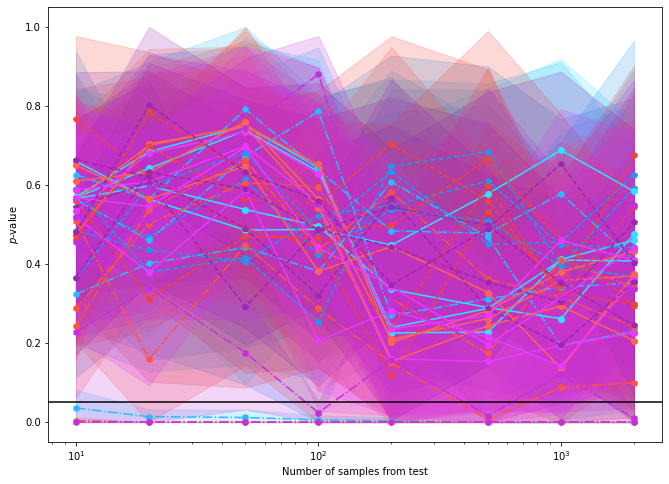

<IPython.core.display.Javascript object>

In [21]:
fig = plt.figure(figsize=(11, 8))
for si, shift in enumerate(shifts):
    for di, dr_technique in enumerate(dr_techniques):
        for mi, md_test in enumerate(md_tests):
            errorfill(
                np.array(samples),
                mean_shifts_dr_md[si, di, mi, :],
                std_shifts_dr_md[si, di, mi, :],
                fmt=linestyles[mi] + markers[mi],
                color=colorscale(colors[si], brightness[mi]),
                label="%s" % "_".join([shift, dr_technique, md_test]),
            )
plt.xlabel("Number of samples from test")
plt.ylabel("$p$-value")
plt.axhline(y=SIGN_LEVEL, color="k")
plt.legend()
plt.show()